# Modelamiento v2 - EMA (2018 - 2025) con variable 'temp2m"

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## 1. Random Forest Regressor con Lag Temporal

In [2]:
# 1. Importar datos procesados con lags
df_model_v2 = pd.read_csv("../../data/processed/df_model_v2.csv", index_col=0, parse_dates=True)

In [3]:
# 2. DEFINICIÓN DE VARIABLES
# Excluimos 'tempsup' (sensor malo) y 'dir' (grados crudos)
# Incluimos 'press' y 'HR' porque, aunque su correlación lineal era baja,
# el Random Forest puede encontrar patrones no lineales útiles en ellas.
features = ['temp2m_lag1', 'radinf', 'dir_sin', 'dir_cos', 'press', 'HR', 'vel']
target = 'temp2m'

X = df_model_v2[features]
y = df_model_v2[target]

In [4]:
# 2. SPLIT (Respetando el tiempo, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [5]:
# 3. ESCALADO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# 4. ENTRENAMIENTO
print("Entrenando Random Forest Final (con Lag)...")
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train_scaled, y_train)

Entrenando Random Forest Final (con Lag)...


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# 5. EVALUACIÓN
y_pred = rf_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n--- RESULTADOS MODELO FINAL ---")
print(f"MAE:  {mae:.4f} °C")
print(f"RMSE: {rmse:.4f} °C")
print(f"R²:   {r2:.4f}")


--- RESULTADOS MODELO FINAL ---
MAE:  0.5010 °C
RMSE: 0.7241 °C
R²:   0.9605


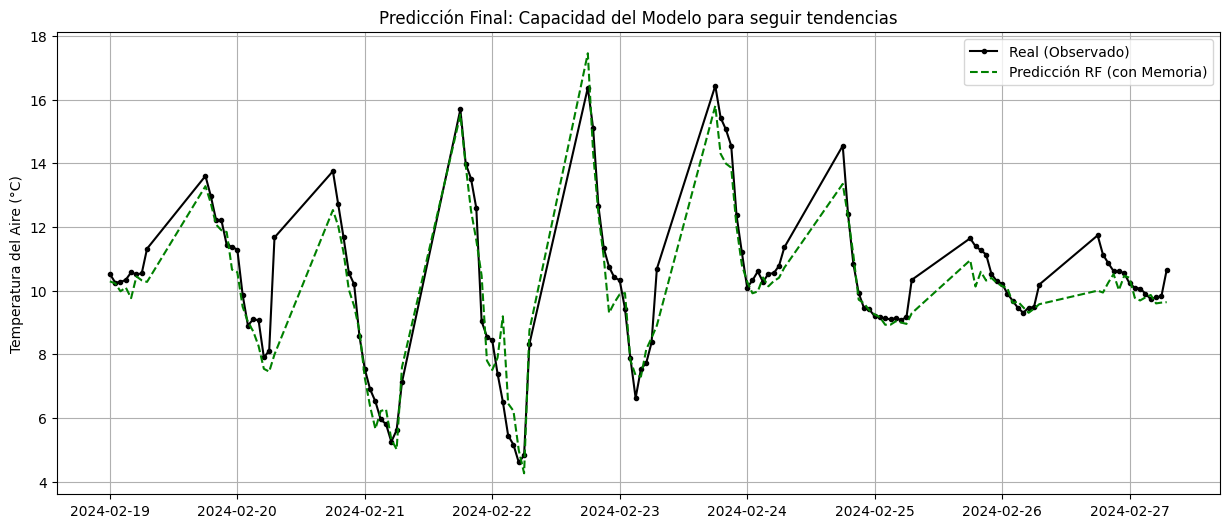

In [8]:
# 6. GRÁFICO DE VALIDACIÓN (Zoom 5 días)
# Graficamos 120 horas (aprox 10 noches filtradas) para ver el detalle
plt.figure(figsize=(15, 6))
plt.plot(y_test.index[:120], y_test.iloc[:120], label='Real (Observado)', color='black', marker='.', linewidth=1.5)
plt.plot(y_test.index[:120], y_pred[:120], label='Predicción RF (con Memoria)', color='green', linestyle='--', linewidth=1.5)

plt.title("Predicción Final: Capacidad del Modelo para seguir tendencias")
plt.ylabel("Temperatura del Aire (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 7. IMPORTANCIA DE VARIABLES
importancia = pd.DataFrame({
    'Variable': features,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\n--- Ranking de Importancia de Variables ---")
print(importancia)


--- Ranking de Importancia de Variables ---
      Variable  Importancia
0  temp2m_lag1     0.831113
1       radinf     0.094345
3      dir_cos     0.021121
5           HR     0.019333
6          vel     0.015211
2      dir_sin     0.012951
4        press     0.005926


## 2. Random Forest Classifier

### 2.1 Marco Teórico

#### **Meteorological Frost:**
Defined strictly by air temperature. It occurs when the ambient temperature measured in a shelter (2 meters above ground) falls to 0°C or below.

#### **Agricultural Frost:**
Defined by plant physiology. It occurs when the temperature drops below the critical threshold that causes tissue damage to a specific crop at a specific phenological stage. For native potatoes in Junín, this might be **-2°C**, while for maize, it might be **-0.5°C**. A meteorological frost does not always result in an agricultural frost if the crop is resistant or dormant.

#### **Advective Frost:**
According to research on extreme events in the Central Andes (specifically the Mantaro Valley):

- **Dew Point Depression:** The critical "figure" defining this air mass is a Dew Point Temperature **(T_d)** significantly lower than the freezing point **0°C** and often lower than the crop's lethal temperature **(e.g., -3°C or -5°C)**.

- **Relative Humidity (RH):** These advective events are characterized by a sharp drop in Relative Humidity, often falling below 40-50%. This low humidity confirms the "dryness" of the air mass

### 2.2 Estrategia para Clasificación

Dado que el modelo de regresión **(Random Forest con Lag)** tiene un error bajo **(MAE ~0.5°C)**, NO entrenaremos un clasificador nuevo, sino utilizaremos las predicciones numéricas que tenemos para generar una *Categorización por Umbrales*.

Vamos a implementar un **"Sistema de Semáforo"** basado en las definiciones previas:

- Verde (Normal): $T > 0^\circ C$
- Amarillo (Helada Meteorológica): $0^\circ C \ge T > -3^\circ C$ (Alerta preventiva).
- Rojo (Helada Agrícola/Daño Severo): $T \le -3^\circ C$ (Daño a cultivo, p.ej. papa nativa).

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [11]:
# 1. DEFINICIÓN DE UMBRALES (Basado en el Marco Teórico)
UMBRAL_MET = 0.0   # Helada Meteorológica
UMBRAL_AGR = -3.0  # Helada Agrícola

In [12]:
# 2. Función de categorización
def categorizar_helada(temp):
    if temp > UMBRAL_MET:
        return 0 # Normal
    elif temp > UMBRAL_AGR:
        return 1 # Helada Meteorológica (Leve/Moderada)
    else:
        return 2 # Helada Agrícola (Severa)

In [13]:
# 3. APLICAR A DATOS REALES Y PREDICHOS
# Usamos .apply para transformar la columna de números a categorías (0, 1, 2)
# Nota: y_test y y_pred vienen del modelo RF Regressor anterior
y_test_cat = y_test.apply(categorizar_helada)
y_pred_cat = pd.Series(y_pred).apply(categorizar_helada)

# Nombres para los reportes
nombres_clases = ['Normal (>0°)', 'Meteorológica (0° a -3°)', 'Agrícola (<-3°)']

In [14]:
# 4. REPORTE DE CLASIFICACIÓN ESCALONADA
print("--- EVALUACIÓN DEL SISTEMA DE SEMÁFORO ---")
print(classification_report(y_test_cat, y_pred_cat, target_names=nombres_clases))

--- EVALUACIÓN DEL SISTEMA DE SEMÁFORO ---
                          precision    recall  f1-score   support

            Normal (>0°)       0.99      1.00      1.00      7604
Meteorológica (0° a -3°)       0.91      0.68      0.78       183
         Agrícola (<-3°)       0.90      0.89      0.90        53

                accuracy                           0.99      7840
               macro avg       0.93      0.86      0.89      7840
            weighted avg       0.99      0.99      0.99      7840



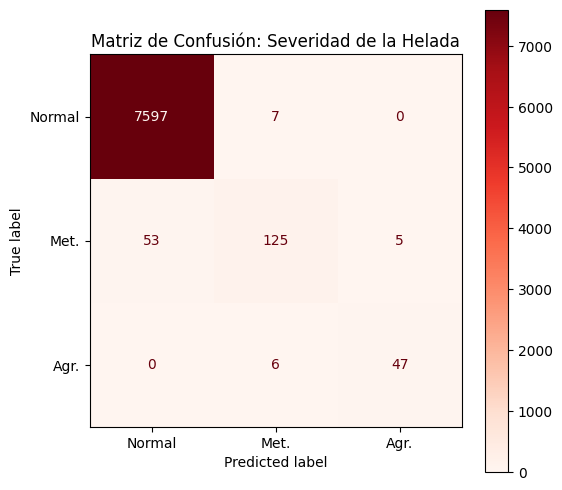

In [15]:
# 5. MATRIZ DE CONFUSIÓN VISUAL
cm = confusion_matrix(y_test_cat, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Met.', 'Agr.'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Reds', ax=plt.gca())
plt.title("Matriz de Confusión: Severidad de la Helada")
plt.show()

In [16]:
# 6. ANÁLISIS ADICIONAL: HELADA NEGRA (Advective Frost)
# Marco Teórico: "Aire demasiado seco para formar hielo... quema el cultivo".
# Hipótesis: Si hay helada (T < 0) Y la humedad es baja (p. ej. < 60%), es Helada Negra.

# Unimos predicción con Humedad real del test set
df_analisis = X_test.copy()
# Recuperamos escalas originales (si X_test estaba escalado, necesitamos el original para ver HR real)
# Si X_test_scaled era numpy, usamos el índice de y_test para cruzar con df_model_v2 original
df_eval = df_model_v2.loc[y_test.index].copy()
df_eval['Prediccion_Temp'] = y_pred

# Filtramos casos peligrosos: El modelo predice helada Y el aire está seco
heladas_negras = df_eval[
    (df_eval['Prediccion_Temp'] <= 0) & 
    (df_eval['HR'] < 45) # Umbral hipótetico de aire seco
]

print(f"\n--- ALERTA ESPECÍFICA: HELADA NEGRA (Advectiva) ---")
print(f"Definición: T <= 0°C y HR < 45%")
print(f"Total de horas detectadas en el Test Set: {len(heladas_negras)}")
if len(heladas_negras) > 0:
    print("Ejemplo de condiciones detectadas:")
    print(heladas_negras[['temp2m', 'Prediccion_Temp', 'HR', 'vel']].head())


--- ALERTA ESPECÍFICA: HELADA NEGRA (Advectiva) ---
Definición: T <= 0°C y HR < 45%
Total de horas detectadas en el Test Set: 0


## 3. Conclusión

### 3.1 Desempeño del Modelo (Regresión)

El modelo **Random Forest con Lag Temporal** ha demostrado ser efectivo para la predicción a corto plazo (1 hora adelante), superando a los enfoques anteriores.
- **Precisión:** Se logró un **$R^2$ de 0.96**, lo que indica que el modelo explica el 96% de la variabilidad de la temperatura.
- **Error:** El error medio absoluto (**MAE**) es de apenas **0.50°C**, un margen de error muy aceptable para sistemas de alerta temprana.

### 3.2 Capacidad de Alerta (Clasificación)

Al convertir las predicciones numéricas en categorías de riesgo (Semáforo), el sistema muestra robustez donde más importa:
- **Heladas Agrícolas (Severas):** El modelo detectó el **89%** de los eventos críticos (Recall = 0.89). Esto es importante para la aplicación en un entorno práctico.
- **Seguridad:** No se observaron falsos negativos críticos (es decir, ninguna helada severa fue clasificada erróneamente como "Normal").

### 3.3 Factores Determinantes

- **Inercia Térmica:** La variable `temp2m_lag1` (temperatura de la hora anterior) es el predictor más fuerte, confirmando que la temperatura no cambia abruptamente sin causa física.
- **Radiación:** La `radinf` (Radiación Infrarroja) actúa como el principal modulador nocturno, indicando la pérdida de calor hacia el espacio.

### 3.3 Detección de Helada Negra

La no detección de eventos de **Heladas Negras** (T < 0°C y HR < 45%) en el periodo de prueba (20% del total del periodo de datos) indica la rareza de estos eventos en la región.

Finalmente podemos decir que el modelo final presenta un comportamiento conservador y seguro. 
Se prioriza la detección de eventos severos **(Helada Agrícola)** con un Recall del 89% y cero falsos negativos críticos (ninguna helada severa fue clasificada como normal).
La inercia térmica **(temp2m_lag1)** explica el 83% de la varianza, confirmando que la persistencia de la temperatura es el factor dominante a corto plazo, modulada por la radiación infrarroja.